In [1]:
import cudf
import pandas as pd
from tqdm import tqdm

In [3]:
# chunksize = 100000000
# readers = [cudf.read_csv('dataset\\tianchi_fresh_comp_train_user_online_partA.txt', sep='\t', header=None, names=['user_id', 'item_id', 'behavior_type', 'user_geohash', 'item_category', 'time'], chunksize=chunksize), cudf.read_csv('dataset\\tianchi_fresh_comp_train_user_online_partB.txt', sep='\t', header=None, names=['user_id', 'item_id', 'behavior_type', 'user_geohash', 'item_category', 'time'], chunksize=chunksize)]
behavior_data = pd.read_csv('dataset/tianchi_fresh_comp_train_user_online_partA.txt', sep='\t', header=None, names=['user_id', 'item_id', 'behavior_type', 'user_geohash', 'item_category', 'time'])
behavior_data = pd.concat([behavior_data, pd.read_csv('dataset/tianchi_fresh_comp_train_user_online_partB.txt', sep='\t', header=None, names=['user_id', 'item_id', 'behavior_type', 'user_geohash', 'item_category', 'time'])])

In [4]:
behavior_data.to_feather('dataset/behavior_data.feather')

In [2]:
behavior_data = pd.read_feather('dataset/behavior_data.feather')

user_behavior = pd.read_feather('feature/user_behavior.feather')

In [38]:
item_data = pd.read_csv('dataset/tianchi_fresh_comp_train_item_online.txt', sep='\t', header=None, names=['item_id', 'item_geohash', 'item_category'])
item_data.to_feather('dataset/item_data.feather')

## 以下进行前期数据统计

In [31]:
# 统计每日购买行为数量
chunksize = len(behavior_data) // 10
buy_status = None
for i in tqdm(range(1, len(behavior_data), chunksize)):
    chunk = behavior_data[i:i+chunksize]
    cudf_chunk = cudf.DataFrame(chunk)
    # time
    cudf_chunk['time'] = cudf_chunk['time'].str.slice(0, 10)
    buy_count = cudf_chunk[cudf_chunk['behavior_type'] == 4].groupby('time').size().reset_index(name='buy_num')
    if buy_status is None:
        buy_status = buy_count
    else:
        buy_status = cudf.concat([buy_status, buy_count])
        buy_status = buy_status.groupby('time').sum().reset_index().sort_values('time')


100%|██████████| 11/11 [02:42<00:00, 14.80s/it]


In [32]:
buy_status = buy_status.to_pandas()
buy_status['time']=pd.to_datetime(buy_status['time'])

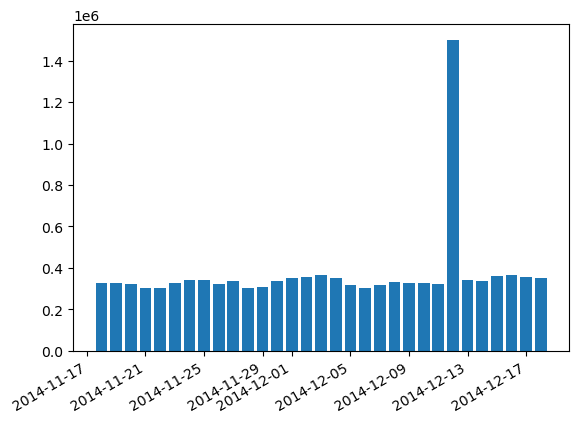

In [24]:
# 绘制条形图
import matplotlib.pyplot as plt
# buy_status['time'] = buy_status['time'].astype('datetime64').sort_values('time')
plt.bar(buy_status['time'].values, buy_status['buy_num'].values)
# 拉长图片
plt.gcf().autofmt_xdate()
plt.show()

In [33]:
# 购买时间转变为字符串
buy_status['time'] = buy_status['time'].astype('str')

In [35]:
buy_status_clean = buy_status[buy_status['time'] != '2014-12-12']
print(buy_status_clean['buy_num'].min(), buy_status_clean['buy_num'].max(), buy_status_clean['buy_num'].mean())

301913 365579 332478.13333333336


## 以下为用户和商品特征提取

In [8]:
user_behavior = behavior_data.groupby(['user_id','item_id'])['behavior_type'].value_counts().unstack(fill_value=0)
user_behavior.rename(columns={1: 'view_count', 2: 'collect_count', 3: 'cart_count', 4: 'buy_count'}, inplace=True)

In [12]:
import feather
user_behavior.reset_index().to_feather('feature/user_behavior.feather')

In [4]:
# 统计用户的总浏览次数、总收藏次数、总加购物车次数、总购买次数
# 计算每次处理的数据量
chunk_size = len(user_behavior) // 10
# 存储最终结果
user_stats = None
item_stats = None

counts = ['view_count','collect_count','cart_count','buy_count']

# 分块处理
for i in range(0, len(user_behavior), chunk_size):
    # 取一个块的数据
    chunk = user_behavior.iloc[i:i + chunk_size]
    # 将 pandas DataFrame 转换为 cudf DataFrame
    cudf_chunk = cudf.from_pandas(chunk)
    # 按用户分组统计
    user_group = cudf_chunk.groupby('user_id')[counts].sum()
    # 按商品分组统计
    item_group = cudf_chunk.groupby('item_id')[counts].sum()
    if user_stats is None:
        user_stats = user_group
        item_stats = item_group
    else:
        user_stats = user_stats.add(user_group, fill_value=0)
        item_stats = item_stats.add(item_group, fill_value=0)

# 将结果转换回 pandas DataFrame
# user_stats = user_stats.to_pandas().reset_index().rename(columns={elem: f'user_{elem}' for elem in counts})
# item_stats = item_stats.to_pandas().reset_index().rename(columns={elem: f'item_{elem}' for elem in counts})
# 修改列名
user_stats = user_stats.reset_index().rename(columns={elem: f'user_{elem}' for elem in counts})
item_stats = item_stats.reset_index().rename(columns={elem: f'item_{elem}' for elem in counts})


In [ ]:
user_stats.to_feather('feature/user_feature.feather')
item_stats.to_feather('feature/item_feature.feather')

In [ ]:
# 合并用户统计结果到原表
user_behavior = pd.merge(user_behavior, user_stats, on='user_id', how='left')
# 合并商品统计结果到原表
user_behavior = pd.merge(user_behavior, item_stats, on='item_id', how='left')

In [6]:
user_stats = cudf.from_pandas(user_stats)
item_stats = cudf.from_pandas(item_stats)
# 将新特征合并到原表中
# 计算每次处理的数据量
chunk_size = len(user_behavior) // 10
# 存储最终结果
user_item_feature = None
# 分块处理
for i in range(0, len(user_behavior), chunk_size):
    chunk = user_behavior.iloc[i:i + chunk_size]
    cudf_chunk = cudf.from_pandas(chunk)
    merged = cudf_chunk.merge(user_stats, on='user_id', how='left')
    merged = merged.merge(item_stats, on='item_id', how='left')
    merged = merged.to_pandas()
    if user_item_feature is None:
        user_item_feature = merged
    else:
        user_item_feature = pd.concat([user_item_feature, merged])

In [12]:
user_item_feature.to_feather('feature/user_item_feature.feather')

In [14]:
user_item_feature = pd.read_feather('feature/user_item_feature.feather')

In [16]:
user_item_feature['user_buy_view_rate'] = user_item_feature['user_buy_count'] / user_item_feature['user_view_count']
user_item_feature['item_buy_view_rate'] = user_item_feature['item_buy_count'] / user_item_feature['item_view_count']

In [18]:
user_item_feature.to_feather('feature/user_item_feature_with_rate.feather')

## 以下开始基于时间跨度对交叉特征进行提取

In [3]:
# 删除user_geohash、item_category列
behavior_data.drop(columns=['user_geohash', 'item_category'], inplace=True)
behavior_data['time'] = pd.to_datetime(behavior_data['time'])

In [ ]:
# 时间范围和对应的列名
time_ranges = [
    (1, '1_day'),
    (3, '3_day'),
    (7, '7_day'),
    (15, '15_day')
]
date_range = pd.date_range('2014-12-16', '2014-12-18', freq='D')
# day = pd.Timestamp('2014-12-16')
final_feature = None
# 计算每次处理的数据量
chunk_size = len(behavior_data) // 10
for day in date_range:
    res_feature = None
    for i in tqdm(range(0, len(behavior_data), chunk_size)):
        chunk = behavior_data.iloc[i:i + chunk_size]
        # 如果 time 是字符串，需要转换为时间戳
        if chunk['time'].dtype == 'O':
            chunk['time'] = pd.to_datetime(chunk['time'])
        chunk = cudf.from_pandas(chunk)
        result_df = None  
        for days, col_name in time_ranges:
            # 按小时统计
            dayd = day - chunk['time']
            time_range_df = chunk[(day >= chunk['time']) & (dayd.dt.seconds <= (days - dayd.dt.days) * 24 * 3600)]
            # time_range_df = chunk[dayd.dt.seconds <= (days - dayd.dt.days) * 24 * 3600]
            # time_range_df = time_range_df.to_pandas()
            behavior_df = None
            for behavior, behavior_name in zip([1, 2, 3, 4], ['view', 'collect', 'cart', 'buy']):
                behavior_count = time_range_df[time_range_df['behavior_type'] == behavior].groupby(['user_id', 'item_id']).size().reset_index(name=f'user_item_{col_name}_{behavior_name}_count')
                if behavior_df is None:
                    behavior_df = behavior_count
                else:
                    behavior_df = behavior_df.merge(behavior_count, on=['user_id', 'item_id'], how='left')
            # del behavior_count
            # 删除 time 列
            # behavior_count.drop(columns='time', inplace=True)
            if result_df is None:
                result_df = behavior_df
            else:
                result_df = result_df.merge(behavior_df, on=['user_id','item_id'], how='left')
        # del behavior_df
        # del time_range_df
        # 添加标签，即预测的日期有购买行为
        label_df = chunk[(day <= chunk['time']) & ((chunk['time'] - day).dt.days < 1) & (chunk['behavior_type'] == 4)].groupby(['user_id', 'item_id']).size().reset_index(name='label')
        # 将标签合并到结果中，如果没有购买行为，则标签为 0
        result_df = result_df.merge(label_df, on=['user_id', 'item_id'], how='outer').fillna(0)
        result_df = result_df.to_pandas()
        if res_feature is None:
            res_feature = result_df
        else:
            res_feature = pd.concat([res_feature, result_df])
            res_feature = res_feature.groupby(['user_id','item_id']).sum().reset_index()
    # del result_df
    # print(len(res_feature))
    res_feature['pred_date'] = day
    # 将标签转化为0-1
    res_feature['label'] = res_feature['label'].apply(lambda x: 1 if x > 0 else 0)
    if final_feature is None:
        final_feature = res_feature
    else:
        final_feature = pd.concat([final_feature, res_feature])
# del res_feature
final_feature

In [5]:
final_feature.to_feather('feature/user_item_timerange_feature.feather')

In [ ]:
import gc
gc.collect()

In [ ]:
user_item_timerange_feature = pd.read_feather('feature/user_item_timerange_feature.feather')
user_item_timerange_feature

In [ ]:
user_item_feature = pd.read_feather('feature/user_item_feature_with_rate.feather')
user_item_feature

In [ ]:
train_feature = final_feature.merge(user_item_feature, on=['user_id', 'item_id'], how='left')

In [ ]:
chunk_size = len(user_item_feature) // 10
user_item_timerange_feature = cudf.from_pandas(user_item_timerange_feature)
train_feature = None
for i in tqdm(range(1, len(user_item_feature), chunk_size)):
    chunk = user_item_feature.iloc[i:i + chunk_size]
    cudf_chunk = cudf.from_pandas(chunk)
    merged = cudf_chunk.merge(user_item_timerange_feature, on=['user_id', 'item_id'], how='inner')
    merged = merged.to_pandas()
    if train_feature is None:
        train_feature = merged
    else:
        train_feature = pd.concat([train_feature, merged])

In [ ]:
train_feature

In [10]:
train_feature.to_feather('feature/train_feature.feather')

## 以下用于构建预测特征

In [ ]:
# 删除user_geohash、item_category列
behavior_data.drop(columns=['user_geohash', 'item_category'], inplace=True)

behavior_data['time'] = pd.to_datetime(behavior_data['time'])

In [ ]:
# 时间范围和对应的列名
time_ranges = [
    (1, '1_day'),
    (3, '3_day'),
    (7, '7_day'),
    (15, '15_day')
]
day = pd.Timestamp('2014-12-19')
# 计算每次处理的数据量
chunk_size = len(behavior_data) // 10
res_feature = None
for i in tqdm(range(0, len(behavior_data), chunk_size)):
    chunk = behavior_data.iloc[i:i + chunk_size]
    # 如果 time 是字符串，需要转换为时间戳
    if chunk['time'].dtype == 'O':
        chunk['time'] = pd.to_datetime(chunk['time'])
    chunk = cudf.from_pandas(chunk)
    result_df = None  
    for days, col_name in time_ranges:
        # 按小时统计
        dayd = day - chunk['time']
        time_range_df = chunk[dayd.dt.seconds <= (days - dayd.dt.days) * 24 * 3600]
        # time_range_df = time_range_df.to_pandas()
        behavior_df = None
        for behavior, behavior_name in zip([1, 2, 3, 4], ['view', 'collect', 'cart', 'buy']):
            behavior_count = time_range_df[time_range_df['behavior_type'] == behavior].groupby(['user_id', 'item_id']).size().reset_index(name=f'user_item_{col_name}_{behavior_name}_count')
            if behavior_df is None:
                behavior_df = behavior_count
            else:
                behavior_df = behavior_df.merge(behavior_count, on=['user_id', 'item_id'], how='left')
        # del behavior_count
        if result_df is None:
            result_df = behavior_df
        else:
            result_df = result_df.merge(behavior_df, on=['user_id','item_id'], how='left')
    # del behavior_df
    # del time_range_df
    result_df = result_df.to_pandas()
    if res_feature is None:
        res_feature = result_df
    else:
        res_feature = pd.concat([res_feature, result_df])
        res_feature = res_feature.groupby(['user_id','item_id']).sum().reset_index()
# del result_df
res_feature

In [ ]:
chunk_size = len(user_item_feature) // 10
user_item_timerange_feature = res_feature
user_item_timerange_feature = cudf.from_pandas(user_item_timerange_feature)
pred_feature = None
for i in tqdm(range(1, len(user_item_feature), chunk_size)):
    chunk = user_item_feature.iloc[i:i + chunk_size]
    cudf_chunk = cudf.from_pandas(chunk)
    merged = cudf_chunk.merge(user_item_timerange_feature, on=['user_id', 'item_id'], how='inner')
    merged = merged.to_pandas()
    if pred_feature is None:
        pred_feature = merged
    else:
        pred_feature = pd.concat([pred_feature, merged])
pred_feature

In [ ]:
pred_feature.to_feather('feature/pred_feature.feather')